# Noise Model Diagnostics: Residuals Autocorrelation Over Time

This example introduces two noise model diagnostics which are useful for studying the autocorrelation in time series noise.

The general procedure we follow in this notebook is to start by performing a fit assuming an IID noise process. Next, we generate the diagnostic plots from the IID residuals, and see if they suggest that a correlated noise process would be applicable.

The two diagnostics demonstrated in this notebook are `pints.residuals_diagnostics.plot_residuals_distance` and `pints.residuals_diagnostics.plot_residuals_binned_autocorrelation`. Both methods can take either a single best fit parameter or an MCMC chain of posterior samples (when the MCMC chain is provided, the posterior median of the residuals will be used). 

## Residuals distance matrix

This diagnostic plot is a distance matrix of the residuals. Correlated noise, such as AR(1) (autoregressive order 1), will cause the distance matrix to exhibit a banded appearance. First, we generate synthetic data according to the logistic model and add IID noise.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Use the toy logistic model
model = toy.LogisticModel()

real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)

# Set up the problem and run the optimisation 
problem = pints.SingleOutputProblem(model, times, values)

score = pints.SumOfSquaresError(problem)
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])
x0 = np.array([0.5, 500])

found_parameters, found_value = pints.optimise(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

print('Score at true solution: ')
print(score(real_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      4589709    0:00.0
1     12     2682172    0:00.0
2     18     2682172    0:00.0
3     24     2682172    0:00.0
20    126    2343892    0:00.0
40    246    1792061    0:00.0
60    366    460742.4   0:00.0
80    486    376496     0:00.0
100   606    376486.2   0:00.0
120   726    376486.2   0:00.1
140   846    376486.2   0:00.1
160   966    376486.2   0:00.1
180   1086   376486.2   0:00.1
200   1206   376486.2   0:00.1
220   1326   376486.2   0:00.1
240   1446   376486.2   0:00.1
260   1566   376486.2   0:00.1
280   1686   376486.2   0:00.1
300   1806   376486.2   0:00.1
320   1926   376486.2   0:00.2
340   2046   376486.2   0:00.2
360   2166   376486.2   0:00.2
380   2286   376486.2   0:00.2
400   2406   376486.2   0:00.2
420   2526   376486.2   0:00.2
440   2646   376486.2   0:00.2
442   2652   376486.2   0:00.2
Halting:

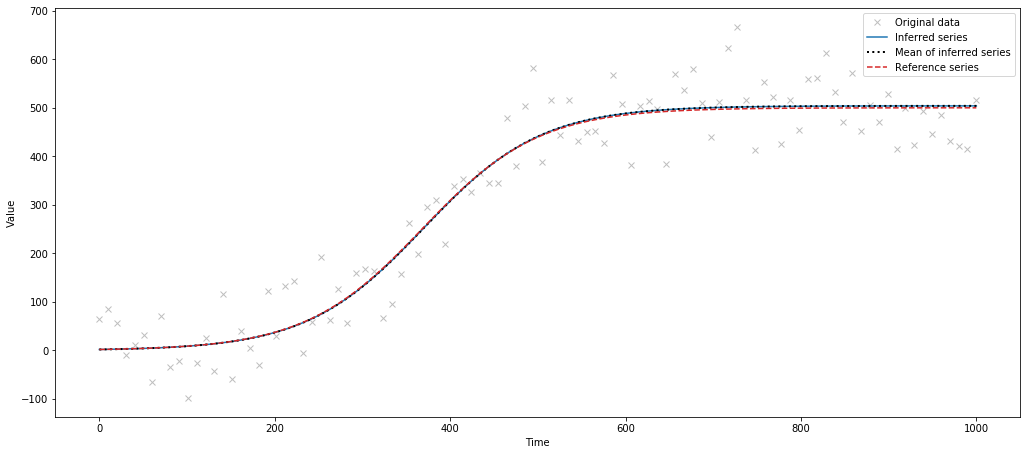

In [2]:
fig, ax = pints.plot.series(np.array([found_parameters]), problem, ref_parameters=real_parameters)
fig.set_size_inches(15, 7.5)
plt.show()

Next, we generate a similar time series, this time with AR(1) noise. 

In [3]:
# Add independent Gaussian noise
rho = 0.85
sigma = 50
values = org_values + pints.noise.ar1(rho, sigma, len(org_values))

# Set up the problem and run the optimisation 
problem_ar1 = pints.SingleOutputProblem(model, times, values)

score = pints.SumOfSquaresError(problem_ar1)
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])
x0 = np.array([0.5, 500])

found_parameters_ar1, found_value_ar1 = pints.optimise(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      4477495    0:00.0
1     12     4461958    0:00.0
2     18     4382337    0:00.0
3     24     4057450    0:00.0
20    126    879752.5   0:00.0
40    246    152971.8   0:00.0
60    366    152368.3   0:00.0
80    486    152367.1   0:00.0
100   606    152367.1   0:00.0
120   726    152367.1   0:00.1
140   846    152367.1   0:00.1
160   966    152367.1   0:00.1
180   1086   152367.1   0:00.1
200   1206   152367.1   0:00.1
220   1326   152367.1   0:00.1
240   1446   152367.1   0:00.1
260   1566   152367.1   0:00.1
280   1686   152367.1   0:00.1
300   1806   152367.1   0:00.1
320   1926   152367.1   0:00.2
340   2046   152367.1   0:00.2
360   2166   152367.1   0:00.2
380   2286   152367.1   0:00.2
400   2406   152367.1   0:00.2
420   2526   152367.1   0:00.2
435   2610   152367.1   0:00.2
Halting: No significant change for 200 

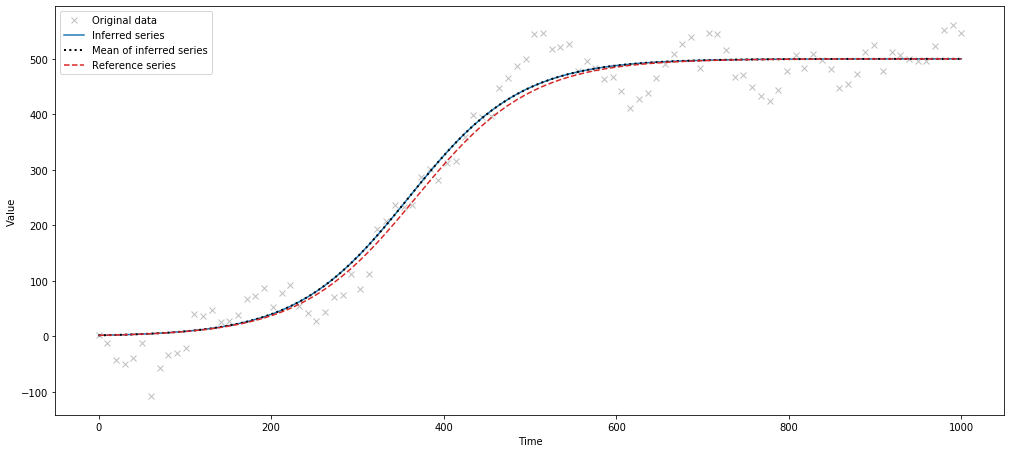

In [4]:
fig, ax = pints.plot.series(np.array([found_parameters_ar1]), problem_ar1, ref_parameters=real_parameters)
fig.set_size_inches(15, 7.5)
plt.show()

Finally, we plot the distance matrix between the residuals for the time series generated above. The plot can be created using the `pints.residuals_diagnostics.plot_residuals_distance` function, which takes as input the fitted parameters and the Pints problem.

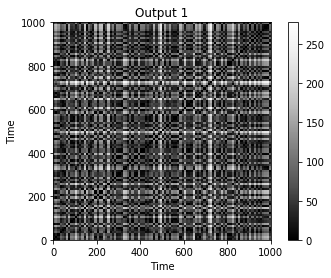

In [5]:
from pints.residuals_diagnostics import plot_residuals_distance

# Plot the distance matrix of the residuals for IID noise
fig = plot_residuals_distance(np.array([found_parameters]),
                              problem)

plt.show()

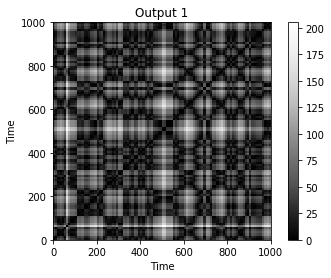

In [6]:
# Plot the distance matrix of the residuals for AR(1) noise
fig = plot_residuals_distance(np.array([found_parameters_ar1]),
                              problem_ar1)

plt.show()

Comparing the two figures above, the matrix for the AR(1) noise time series clearly shows a banded appearance. This plot suggests that the IID noise assumption we made when fitting the model is probably inadequate, and we should rerun the fit using a correlated noise model.

## Binned residuals autocorrelation

The next diagnostic plot divides the time series into consecutive bins, and displays the lag 1 autocorrelation of the residuals calculated within each bin over time. This function is available from Pints using `pints.residuals_diagnostics.plot_residuals_binned_autocorrelation`. 

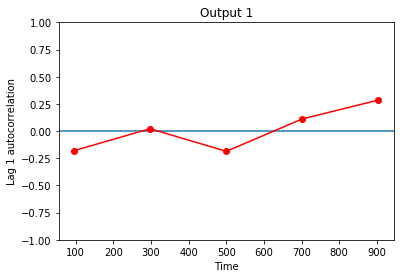

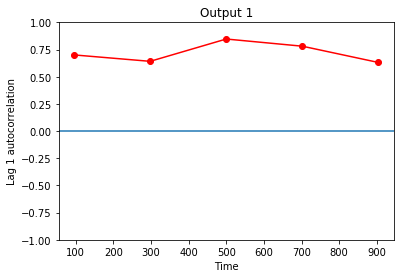

In [7]:
from pints.residuals_diagnostics import plot_residuals_binned_autocorrelation

fig = plot_residuals_binned_autocorrelation(
    np.array([found_parameters]),
    problem,
    n_bins=5
)

fig = plot_residuals_binned_autocorrelation(
    np.array([found_parameters_ar1]),
    problem_ar1,
    n_bins=5
)

plt.show()

Similar to the distance matrix diagnostic, these plots indicate a high autocorrelation over time for the problem with AR(1) noise.

The binned autocorrelation diagnostic is particularly helpful for detecting noise processes in which the level of correlation is changing over time. For a final example, we generate a time series with IID noise in the first half, and AR(1) noise in the second half. As before, we then fit the parameters assuming IID noise, and look at the diagnostic plots to evaluate the noise model.

In [8]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Use the toy logistic model
model = toy.LogisticModel()

real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 500)
org_values = model.simulate(real_parameters, times)

# Make half IID noise and half AR(1) noise
noise = 50
rho = 0.9
sigma = 50
values = org_values + \
    np.concatenate((np.random.normal(0, noise, len(org_values)//2), 
                    pints.noise.ar1(rho, sigma, len(org_values)//2)))

# Set up the problem and run the optimisation 
problem_mixed = pints.SingleOutputProblem(model, times, values)

score = pints.SumOfSquaresError(problem_mixed)
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])
x0 = np.array([0.5, 500])

found_parameters_mixed, found_value_mixed = pints.optimise(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      2.4e+07    0:00.0
1     12     1.65e+07   0:00.0
2     18     1.65e+07   0:00.0
3     24     1.65e+07   0:00.0
20    126    2167424    0:00.0
40    246    2167424    0:00.1
60    366    1369024    0:00.1
80    486    1313897    0:00.1
100   606    1313896    0:00.1
120   726    1313896    0:00.1
140   846    1313896    0:00.1
160   966    1313896    0:00.1
180   1086   1313896    0:00.1
200   1206   1313896    0:00.1
220   1326   1313896    0:00.1
240   1446   1313896    0:00.2
260   1566   1313896    0:00.2
280   1686   1313896    0:00.2
300   1806   1313896    0:00.2
320   1926   1313896    0:00.2
340   2046   1313896    0:00.2
360   2166   1313896    0:00.2
365   2190   1313896    0:00.2
Halting: No significant change for 200 iterations.


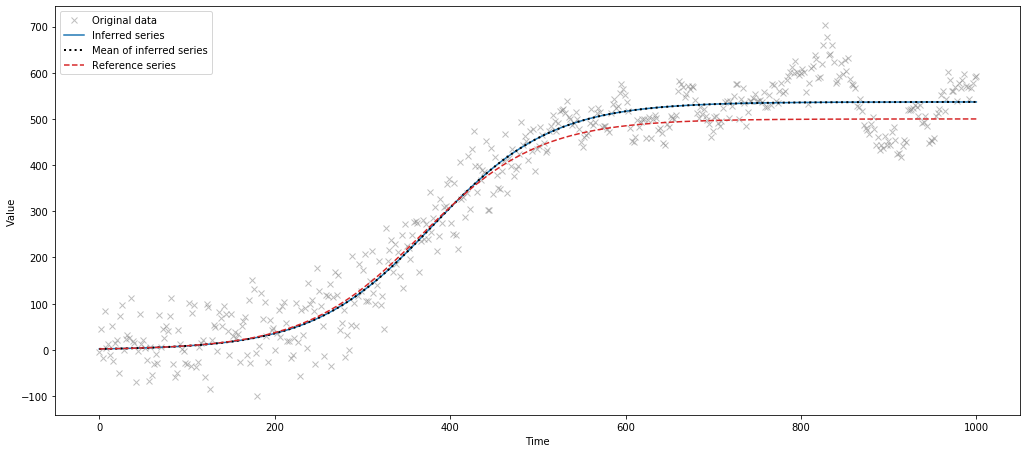

In [9]:
fig, ax = pints.plot.series(np.array([found_parameters_mixed]), problem_mixed, ref_parameters=real_parameters)
fig.set_size_inches(15, 7.5)
plt.show()

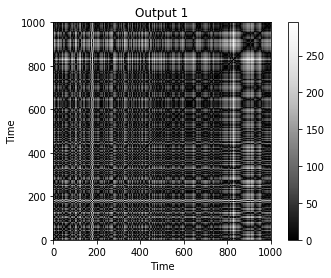

In [10]:
fig = plot_residuals_distance(np.array([found_parameters_mixed]),
                              problem_mixed)

plt.show()

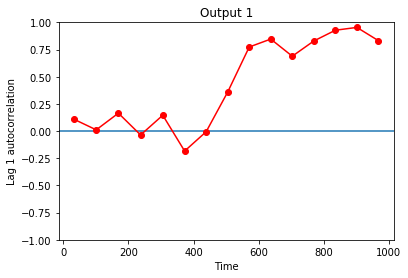

In [11]:
fig = plot_residuals_binned_autocorrelation(
    np.array([found_parameters_mixed]),
    problem_mixed,
    n_bins=15
)

plt.show()

Both of the two diagnostic plots shown above help to reveal the autocorrelated noise that appears in the second half of the time series, from t=500 to t=1000.